<a href="https://colab.research.google.com/github/wasimsse/BERTopicDependsMapper-/blob/main/BERTopicDependsMapper_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bertopic
!pip install gitpython
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install glob2
!pip install -U kaleido
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from git import Repo
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 15.9 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039283 sha256=8765797ff7291d5f0369c67aaa171f493627eae6548957d810a29d1e68d1a66a
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

In [2]:
# Function to remove programming keywords
def remove_keywords(text, keywords):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in keywords]
    return ' '.join(filtered_words)

# List of common programming keywords(We can extend more)
programming_keywords = ['if', 'else', 'while', 'for', 'break', 'continue',
                        'return', 'class', 'def', 'import', 'from', 'try',
                        'except', 'with', 'as', 'pass', 'raise', 'lambda',
                        'yield', 'void', 'int', 'float', 'char', 'double',
                        'public', 'private', 'protected', 'static', 'final',
                        'package', 'import', 'try', 'catch', 'finally', 'this',
                        'new', 'null', 'true', 'false', 'switch', 'case',
                        'default', 'do', 'while', 'for', 'continue', 'break',
                        'const', 'goto', 'sizeof', 'typedef', 'struct', 'enum',
                        'union', 'namespace', 'template', 'explicit', 'friend',
                        'inline', 'virtual', 'override', 'bool', 'using', 'std',
                        'string', 'throws']

# Enable inline plotting for Jupyter environments
%matplotlib inline

# Function to read files and return file contents and folder-file mapping
def read_files_with_folder_info(directory):
    file_contents = []
    folder_file_map = {}
    for extension in ["*.java", "*.py", "*.cpp", "*.h"]:
        for file_path in glob.glob(f"{directory}/**/{extension}", recursive=True):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                file_contents.append(content)
                folder = os.path.dirname(file_path)
                folder_file_map.setdefault(folder, []).append(file_path)
    return file_contents, folder_file_map

# Clone and read files from each tag
repo_url = "https://github.com/multilang-depends/depends.git"
tags = ["v0.9.0", "v0.9.1", "v0.9.1a", "v0.9.2", "0.9.3"]
tagged_files = {}

for tag in tags:
    dir_name = f"Repo_{tag}"
    if not os.path.exists(dir_name):
        print(f"Cloning and checking out tag {tag}...")
        repo = Repo.clone_from(repo_url, dir_name)
        repo.git.checkout(tag)
    files, folder_map = read_files_with_folder_info(dir_name)
    tagged_files[tag] = files
    print(f"Cloning and initial file reading for tag {tag} completed.")

Cloning and checking out tag v0.9.0...
Cloning and initial file reading for tag v0.9.0 completed.
Cloning and checking out tag v0.9.1...
Cloning and initial file reading for tag v0.9.1 completed.
Cloning and checking out tag v0.9.1a...
Cloning and initial file reading for tag v0.9.1a completed.
Cloning and checking out tag v0.9.2...
Cloning and initial file reading for tag v0.9.2 completed.
Cloning and checking out tag 0.9.3...
Cloning and initial file reading for tag 0.9.3 completed.


In [3]:
topic_models = {}
MIN_DOCUMENTS = 5  # Minimum number of documents required for modeling

for tag, texts in tagged_files.items():
    print(f"Starting BERTopic modeling for tag: {tag}...")
    if len(texts) < MIN_DOCUMENTS:
        print(f"Skipping tag {tag} due to insufficient data.")
        continue

    try:
        topic_model = BERTopic(verbose=True)
        topics, _ = topic_model.fit_transform(texts)
        topic_models[tag] = topic_model

        # Check if topics were created
        if topic_model.get_topic_info().shape[0] > 1:  # More than 1 topic (excluding -1)
            print(",,,.")
           # fig = topic_model.visualize_topics()
            #fig.show()

            # Optionally save the visualization as an image
            #fig.write_image(f"Intertopic_Distance_Map_{tag}.png")
        else:
            print(f"No meaningful topics found for tag {tag}.")

    except Exception as e:
        print(f"An error occurred during BERTopic modeling for tag {tag}: {e}")

    print(f"BERTopic modeling for tag {tag} completed.\n")

2024-03-06 16:47:01,288 - BERTopic - Embedding - Transforming documents to embeddings.


Starting BERTopic modeling for tag: v0.9.0...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2024-03-06 16:47:10,209 - BERTopic - Embedding - Completed ✓
2024-03-06 16:47:10,211 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:47:18,141 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:47:18,143 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:47:18,156 - BERTopic - Cluster - Completed ✓
2024-03-06 16:47:18,167 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:47:18,266 - BERTopic - Representation - Completed ✓
2024-03-06 16:47:18,331 - BERTopic - Embedding - Transforming documents to embeddings.


,,,.
BERTopic modeling for tag v0.9.0 completed.

Starting BERTopic modeling for tag: v0.9.1...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-03-06 16:47:20,874 - BERTopic - Embedding - Completed ✓
2024-03-06 16:47:20,876 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:47:23,051 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:47:23,053 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:47:23,067 - BERTopic - Cluster - Completed ✓
2024-03-06 16:47:23,072 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:47:23,162 - BERTopic - Representation - Completed ✓
2024-03-06 16:47:23,225 - BERTopic - Embedding - Transforming documents to embeddings.


,,,.
BERTopic modeling for tag v0.9.1 completed.

Starting BERTopic modeling for tag: v0.9.1a...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-03-06 16:47:25,308 - BERTopic - Embedding - Completed ✓
2024-03-06 16:47:25,310 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:47:27,962 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:47:27,963 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:47:27,977 - BERTopic - Cluster - Completed ✓
2024-03-06 16:47:27,983 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:47:28,086 - BERTopic - Representation - Completed ✓
2024-03-06 16:47:28,152 - BERTopic - Embedding - Transforming documents to embeddings.


,,,.
BERTopic modeling for tag v0.9.1a completed.

Starting BERTopic modeling for tag: v0.9.2...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-03-06 16:47:30,577 - BERTopic - Embedding - Completed ✓
2024-03-06 16:47:30,579 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:47:33,508 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:47:33,510 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:47:33,522 - BERTopic - Cluster - Completed ✓
2024-03-06 16:47:33,527 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:47:33,619 - BERTopic - Representation - Completed ✓
2024-03-06 16:47:33,692 - BERTopic - Embedding - Transforming documents to embeddings.


,,,.
BERTopic modeling for tag v0.9.2 completed.

Starting BERTopic modeling for tag: 0.9.3...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-03-06 16:47:35,839 - BERTopic - Embedding - Completed ✓
2024-03-06 16:47:35,843 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:47:38,045 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:47:38,047 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:47:38,061 - BERTopic - Cluster - Completed ✓
2024-03-06 16:47:38,066 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:47:38,164 - BERTopic - Representation - Completed ✓


,,,.
BERTopic modeling for tag 0.9.3 completed.



In [4]:
# Combine top words from the top 10 topics across all releases
all_top_words = set()
for model in topic_models.values():
    top_topics = model.get_topic_freq().head(11)  # Top 10 topics (excluding -1)
    for topic_num in top_topics['Topic']:
        if topic_num != -1:  # Exclude the -1 (outlier) topic
            topic = model.get_topic(topic_num)
            top_words = [word for word, _ in topic]
            all_top_words.update(top_words)

# Fit the CountVectorizer to the combined top words
vectorizer = CountVectorizer()
vectorizer.fit(list(all_top_words))

# Transform top 10 topics to word vectors for each release
topic_vectors = {}
for tag, model in topic_models.items():
    top_topics = model.get_topic_freq().head(11)  # Top 10 topics (excluding -1)
    topic_words = []
    for topic_num in top_topics['Topic']:
        if topic_num != -1:  # Exclude the -1 topic
            topic = model.get_topic(topic_num)
            words = " ".join([word for word, _ in topic])
            topic_words.append(words)
    topic_vectors[tag] = vectorizer.transform(topic_words)

# Compute Cosine Similarity for top 10 topics in different releases
cosine_similarities = {}
for tag1, vectors1 in topic_vectors.items():
    for tag2, vectors2 in topic_vectors.items():
        if tag1 != tag2:
            cosine_sim_matrix = cosine_similarity(vectors1, vectors2)
            cosine_similarities[(tag1, tag2)] = cosine_sim_matrix

# Visualization of Intertopic Distance Map
for tag, model in topic_models.items():
    try:
        print(f"Visualizing topics for {tag}...")
        fig = model.visualize_topics()
        fig.write_html(f"Intertopic_Distance_Map_{tag}.html")  # Save as HTML
        fig.show()
    except Exception as e:
        print(f"Error visualizing topics for {tag}: {e}")

Visualizing topics for v0.9.0...


Visualizing topics for v0.9.1...


Visualizing topics for v0.9.1a...


Visualizing topics for v0.9.2...


Visualizing topics for 0.9.3...


In [5]:
# Install necessary packages
!pip install gitpython
!pip install bertopic
!pip install kaleido
!pip install scikit-learn
!pip install pandas

import sys
from git import Repo
import glob
import os
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter environments
%matplotlib inline

# Define programming keywords to be removed
programming_keywords = ['if', 'else', 'while', 'for', 'break', 'continue',
                        'return', 'class', 'def', 'import', 'from', 'try',
                        'except', 'with', 'as', 'pass', 'raise', 'lambda',
                        'yield', 'void', 'int', 'float', 'char', 'double',
                        'public', 'private', 'protected', 'static', 'final',
                        'package', 'import', 'try', 'catch', 'finally', 'this',
                        'new', 'null', 'true', 'false', 'switch', 'case',
                        'default', 'do', 'while', 'for', 'continue', 'break',
                        'const', 'goto', 'sizeof', 'typedef', 'struct', 'enum',
                        'union', 'namespace', 'template', 'explicit', 'friend',
                        'inline', 'virtual', 'override', 'bool', 'using', 'std',
                        'string', 'throws'] #We can add more programming keywords here

# Function to remove programming keywords
def remove_keywords(text, keywords):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in keywords]
    return ' '.join(filtered_words)

# Function to read files and return file contents
def read_files_with_folder_info(directory):
    file_contents = []
    folder_file_map = {}
    for extension in ["*.java", "*.py", "*.cpp", "*.h"]:
        for file_path in glob.glob(f"{directory}/**/{extension}", recursive=True):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                cleaned_content = remove_keywords(content, programming_keywords)
                file_contents.append(cleaned_content)
                folder = os.path.dirname(file_path)
                folder_file_map.setdefault(folder, []).append(file_path)
    return file_contents, folder_file_map

# Clone and read files from each tag
repo_url = "https://github.com/multilang-depends/depends.git"
tags = ["v0.9.0", "v0.9.1", "v0.9.1a", "v0.9.2", "0.9.3"]
tagged_files = {}

for tag in tags:
    dir_name = f"Repo_{tag}"
    if not os.path.exists(dir_name):
        print(f"Cloning and checking out tag {tag}...")
        repo = Repo.clone_from(repo_url, dir_name)
        repo.git.checkout(tag)
    files, folder_map = read_files_with_folder_info(dir_name)
    tagged_files[tag] = files
    print(f"Cloning and initial file reading for tag {tag} completed.")

# BERTopic modeling for each tag
topic_models = {}
release_topics = {}
release_dfs = {}

for tag, texts in tagged_files.items():
    print(f"Starting BERTopic modeling for tag: {tag}...")
    if len(texts) < 5:  # Minimum number of documents required for modeling
        print(f"Skipping tag {tag} due to insufficient data.")
        continue

    try:
        topic_model = BERTopic(verbose=True, calculate_probabilities=True)
        topics, _ = topic_model.fit_transform(texts)
        topic_models[tag] = topic_model
        release_topics[tag] = topics
        df = pd.DataFrame({"Doc": range(len(texts)), "Topic": topics})
        release_dfs[tag] = df

        print(f"BERTopic modeling for tag {tag} completed.")
    except Exception as e:
        print(f"An error occurred during BERTopic modeling for tag {tag}: {e}")

def print_topics(topic_models):
    for tag, model in topic_models.items():
        print(f"Topics for {tag}:")
        topics = model.get_topic_info()
        print(topics)

def export_topics_to_csv(topic_models, output_file):
    all_topics = pd.DataFrame()
    for tag, model in topic_models.items():
        topics = model.get_topic_info()
        topics['Tag'] = tag  # Add a column to identify the tag
        all_topics = pd.concat([all_topics, topics], ignore_index=True)
    all_topics.to_csv(output_file, index=False)

# Example usage
print_topics(topic_models)
export_topics_to_csv(topic_models, "all_topics.csv")


Cloning and initial file reading for tag v0.9.0 completed.
Cloning and initial file reading for tag v0.9.1 completed.
Cloning and initial file reading for tag v0.9.1a completed.
Cloning and initial file reading for tag v0.9.2 completed.


2024-03-06 16:53:22,932 - BERTopic - Embedding - Transforming documents to embeddings.


Cloning and initial file reading for tag 0.9.3 completed.
Starting BERTopic modeling for tag: v0.9.0...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2024-03-06 16:53:25,099 - BERTopic - Embedding - Completed ✓
2024-03-06 16:53:25,101 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:53:27,919 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:53:27,926 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:53:27,956 - BERTopic - Cluster - Completed ✓
2024-03-06 16:53:27,966 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:53:28,098 - BERTopic - Representation - Completed ✓
2024-03-06 16:53:28,180 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.0 completed.
Starting BERTopic modeling for tag: v0.9.1...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-03-06 16:53:30,418 - BERTopic - Embedding - Completed ✓
2024-03-06 16:53:30,420 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:53:32,621 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:53:32,623 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:53:32,642 - BERTopic - Cluster - Completed ✓
2024-03-06 16:53:32,647 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:53:32,729 - BERTopic - Representation - Completed ✓
2024-03-06 16:53:32,778 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.1 completed.
Starting BERTopic modeling for tag: v0.9.1a...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-03-06 16:53:34,822 - BERTopic - Embedding - Completed ✓
2024-03-06 16:53:34,826 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:53:37,033 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:53:37,035 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:53:37,055 - BERTopic - Cluster - Completed ✓
2024-03-06 16:53:37,061 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:53:37,702 - BERTopic - Representation - Completed ✓
2024-03-06 16:53:37,760 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.1a completed.
Starting BERTopic modeling for tag: v0.9.2...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-03-06 16:53:40,119 - BERTopic - Embedding - Completed ✓
2024-03-06 16:53:40,122 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:53:43,032 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:53:43,034 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:53:43,056 - BERTopic - Cluster - Completed ✓
2024-03-06 16:53:43,062 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:53:43,153 - BERTopic - Representation - Completed ✓
2024-03-06 16:53:43,216 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.2 completed.
Starting BERTopic modeling for tag: 0.9.3...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-03-06 16:53:45,467 - BERTopic - Embedding - Completed ✓
2024-03-06 16:53:45,471 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-06 16:53:47,708 - BERTopic - Dimensionality - Completed ✓
2024-03-06 16:53:47,710 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-06 16:53:47,731 - BERTopic - Cluster - Completed ✓
2024-03-06 16:53:47,736 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-06 16:53:47,821 - BERTopic - Representation - Completed ✓


BERTopic modeling for tag 0.9.3 completed.
Topics for v0.9.0:
   Topic  Count                                             Name  \
0      0    123                             0_the_software_to_of   
1      1     83                 1_string_test_ioexception_parser   
2      2     18  2_string_createfileparsersrc_fileparser_srcsrcs   

                                      Representation  \
0  [the, software, to, of, or, in, is, and, witho...   
1  [string, test, ioexception, parser, parserpars...   
2  [string, createfileparsersrc, fileparser, srcs...   

                                 Representative_Docs  
0  [/* MIT License Copyright (c) 2018-2019 Gang Z...  
1  [depends.extractor.cpp; org.junit.Assert.asser...  
2  [depends.extractor.ruby; java.io.IOException; ...  
Topics for v0.9.1:
   Topic  Count                                             Name  \
0      0    122                             0_the_software_to_of   
1      1    122                 1_string_test_ioexception_parser 

In [6]:
# ... (previous parts of the script) ...

# Combine top words from the top 10 topics across all releases
all_top_words = set()
for model in topic_models.values():
    top_topics = model.get_topic_freq().head(11)  # Top 10 topics (excluding -1)
    for topic_num in top_topics['Topic']:
        if topic_num != -1:  # Exclude the -1 (outlier) topic
            topic = model.get_topic(topic_num)
            top_words = [word for word, _ in topic]
            all_top_words.update(top_words)

# Fit the CountVectorizer to the combined top words
vectorizer = CountVectorizer()
vectorizer.fit(list(all_top_words))

# Transform top 10 topics to word vectors for each release
topic_vectors = {}
for tag, model in topic_models.items():
    top_topics = model.get_topic_freq().head(11)  # Top 10 topics (excluding -1)
    topic_words = []
    for topic_num in top_topics['Topic']:
        if topic_num != -1:  # Exclude the -1 topic
            topic = model.get_topic(topic_num)
            words = " ".join([word for word, _ in topic])
            topic_words.append(words)
    topic_vectors[tag] = vectorizer.transform(topic_words)

# Compute Cosine Similarity for top 10 topics in different releases
cosine_similarities = {}
for tag1, vectors1 in topic_vectors.items():
    for tag2, vectors2 in topic_vectors.items():
        if tag1 != tag2:
            cosine_sim_matrix = cosine_similarity(vectors1, vectors2)
            cosine_similarities[(tag1, tag2)] = cosine_sim_matrix

# Visualization of Intertopic Distance Map
for tag, model in topic_models.items():
    try:
        print(f"Visualizing topics for {tag}...")
        fig = model.visualize_topics()
        fig.write_html(f"Intertopic_Distance_Map_{tag}.html")  # Save as HTML
        fig.show()
    except Exception as e:
        print(f"Error visualizing topics for {tag}: {e}")

# Example usage
print_topics(topic_models)
export_topics_to_csv(topic_models, "all_topics.csv")


Visualizing topics for v0.9.0...
Error visualizing topics for v0.9.0: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.
Visualizing topics for v0.9.1...
Error visualizing topics for v0.9.1: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.
Visualizing topics for v0.9.1a...


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Visualizing topics for v0.9.2...


Visualizing topics for 0.9.3...


Topics for v0.9.0:
   Topic  Count                                             Name  \
0      0    123                             0_the_software_to_of   
1      1     83                 1_string_test_ioexception_parser   
2      2     18  2_string_createfileparsersrc_fileparser_srcsrcs   

                                      Representation  \
0  [the, software, to, of, or, in, is, and, witho...   
1  [string, test, ioexception, parser, parserpars...   
2  [string, createfileparsersrc, fileparser, srcs...   

                                 Representative_Docs  
0  [/* MIT License Copyright (c) 2018-2019 Gang Z...  
1  [depends.extractor.cpp; org.junit.Assert.asser...  
2  [depends.extractor.ruby; java.io.IOException; ...  
Topics for v0.9.1:
   Topic  Count                                             Name  \
0      0    122                             0_the_software_to_of   
1      1    122                 1_string_test_ioexception_parser   
2      2     18  2_string_createfilepars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 14.1 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.4 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039283 sha256=603a780ab21e4cb9dbe623d7dd7e27b782245

2024-01-31 11:35:28,700 - BERTopic - Embedding - Transforming documents to embeddings.


Cloning and initial file reading for tag 0.9.3 completed.
Starting BERTopic modeling for tag: v0.9.0...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2024-01-31 11:36:13,619 - BERTopic - Embedding - Completed ✓
2024-01-31 11:36:13,623 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-31 11:36:24,291 - BERTopic - Dimensionality - Completed ✓
2024-01-31 11:36:24,293 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-31 11:36:24,305 - BERTopic - Cluster - Completed ✓
2024-01-31 11:36:24,316 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-31 11:36:24,423 - BERTopic - Representation - Completed ✓
2024-01-31 11:36:24,481 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.0 completed.
Starting BERTopic modeling for tag: v0.9.1...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-31 11:37:08,879 - BERTopic - Embedding - Completed ✓
2024-01-31 11:37:08,883 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-31 11:37:11,486 - BERTopic - Dimensionality - Completed ✓
2024-01-31 11:37:11,488 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-31 11:37:11,502 - BERTopic - Cluster - Completed ✓
2024-01-31 11:37:11,508 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-31 11:37:11,600 - BERTopic - Representation - Completed ✓
2024-01-31 11:37:11,662 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.1 completed.
Starting BERTopic modeling for tag: v0.9.1a...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-31 11:37:55,698 - BERTopic - Embedding - Completed ✓
2024-01-31 11:37:55,701 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-31 11:37:58,741 - BERTopic - Dimensionality - Completed ✓
2024-01-31 11:37:58,745 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-31 11:37:58,759 - BERTopic - Cluster - Completed ✓
2024-01-31 11:37:58,767 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-31 11:37:58,866 - BERTopic - Representation - Completed ✓
2024-01-31 11:37:58,924 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.1a completed.
Starting BERTopic modeling for tag: v0.9.2...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-31 11:38:44,218 - BERTopic - Embedding - Completed ✓
2024-01-31 11:38:44,220 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-31 11:38:47,763 - BERTopic - Dimensionality - Completed ✓
2024-01-31 11:38:47,765 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-31 11:38:47,780 - BERTopic - Cluster - Completed ✓
2024-01-31 11:38:47,785 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-31 11:38:48,505 - BERTopic - Representation - Completed ✓
2024-01-31 11:38:48,569 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.2 completed.
Starting BERTopic modeling for tag: 0.9.3...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-01-31 11:39:35,271 - BERTopic - Embedding - Completed ✓
2024-01-31 11:39:35,274 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-31 11:39:38,327 - BERTopic - Dimensionality - Completed ✓
2024-01-31 11:39:38,330 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-31 11:39:38,345 - BERTopic - Cluster - Completed ✓
2024-01-31 11:39:38,351 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-31 11:39:38,456 - BERTopic - Representation - Completed ✓


BERTopic modeling for tag 0.9.3 completed.


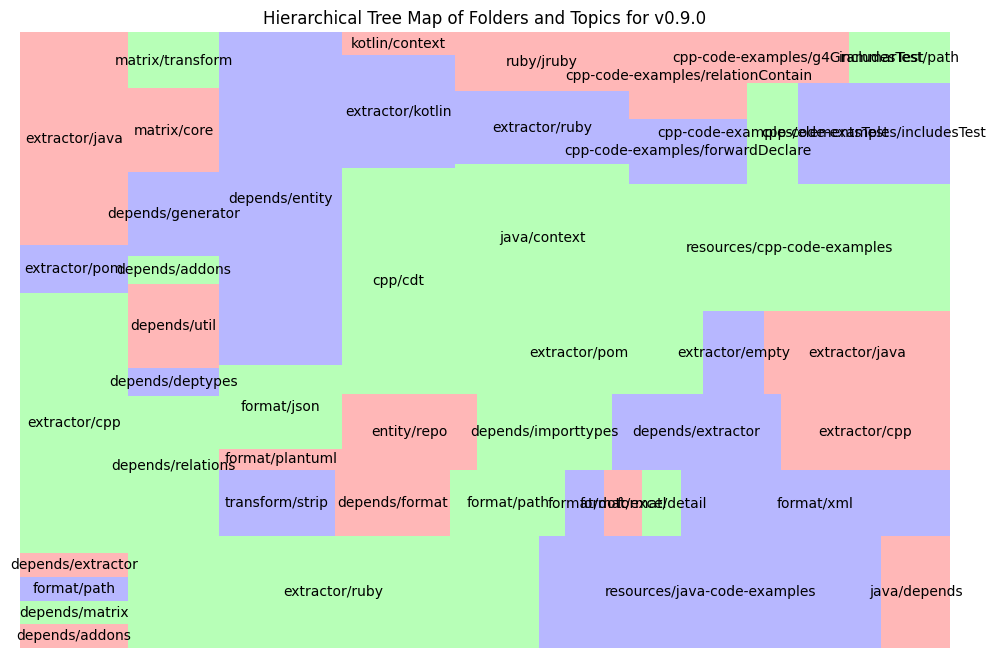

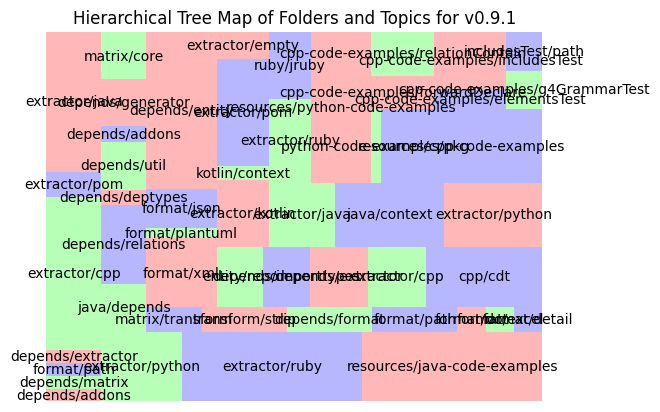

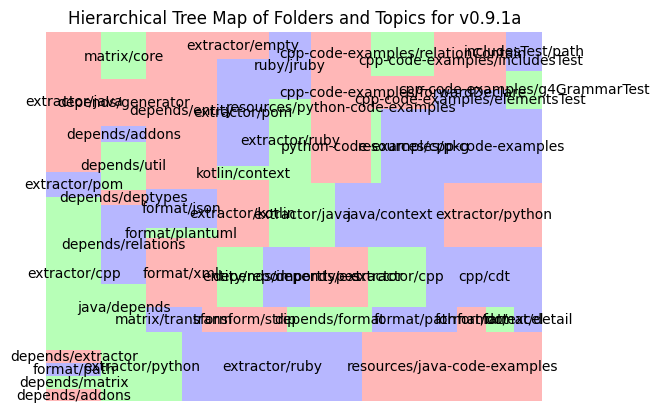

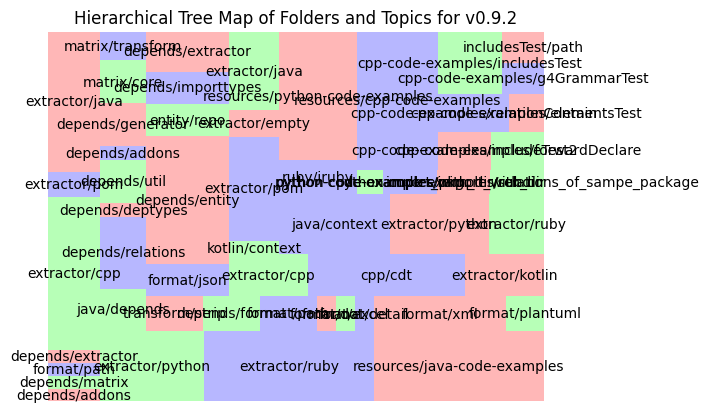

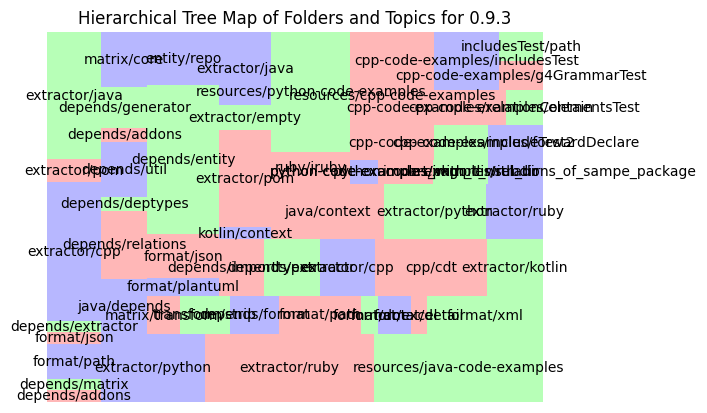

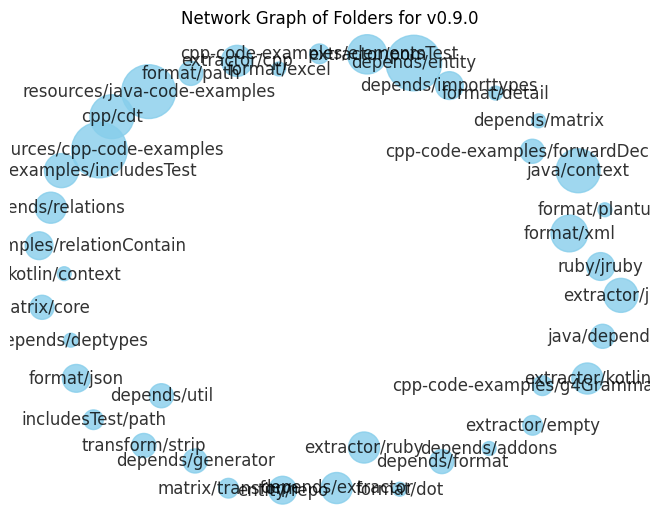

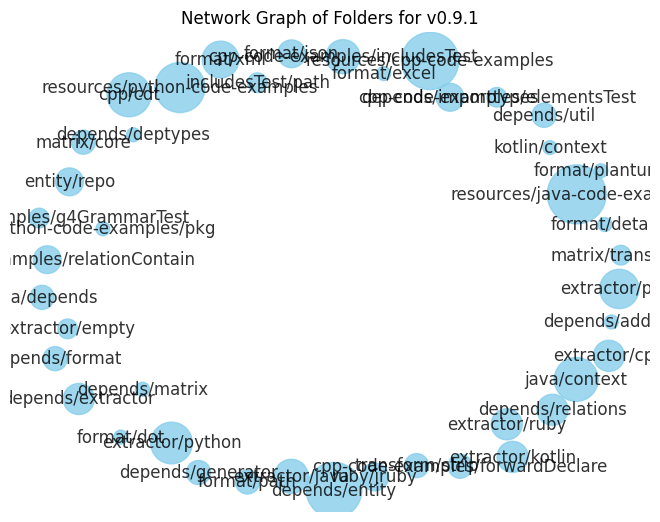

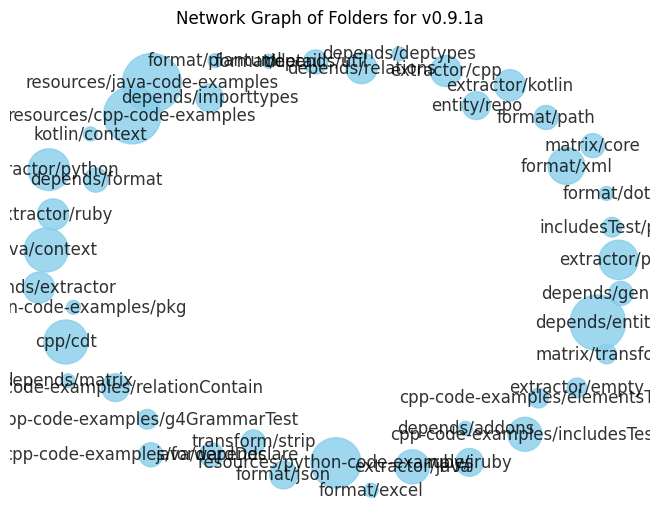

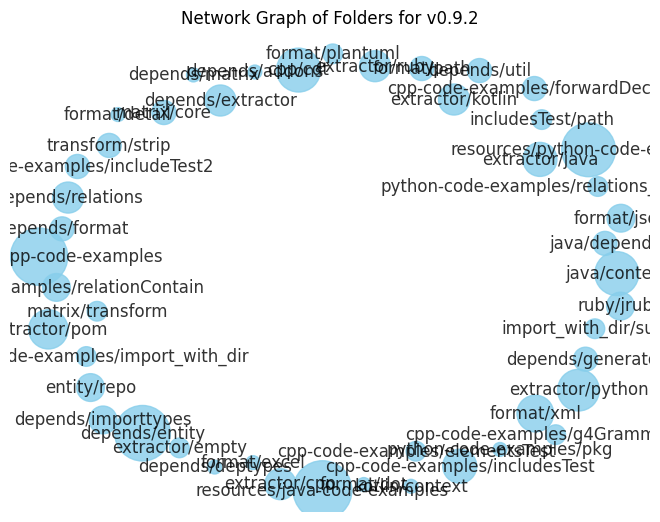

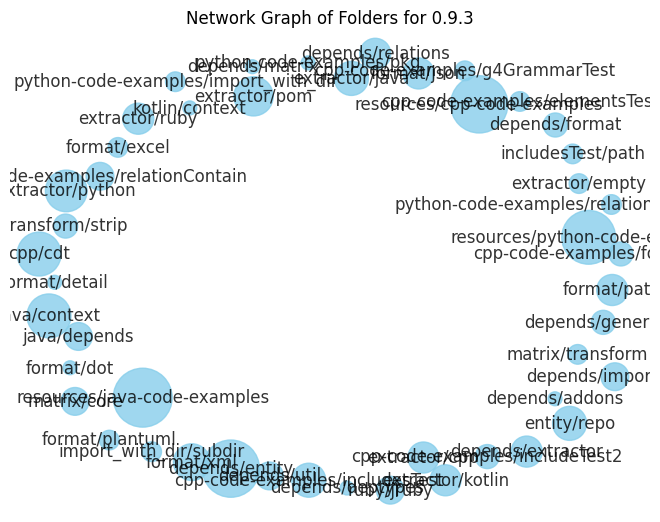

In [ ]:
# Install necessary packages
!pip install gitpython
!pip install bertopic
!pip install squarify
!pip install networkx
!pip install matplotlib

import os
import glob
import squarify
import matplotlib.pyplot as plt
import networkx as nx
from git import Repo
from bertopic import BERTopic

# Function to remove programming keywords from text
programming_keywords = ['if', 'else', 'while', 'for', 'break', 'continue',
                        'return', 'class', 'def', 'import', 'from', 'try',
                        'except', 'with', 'as', 'pass', 'raise', 'lambda',
                        'yield', 'void', 'int', 'float', 'char', 'double',
                        'public', 'private', 'protected', 'static', 'final',
                        'package', 'import', 'try', 'catch', 'finally', 'this',
                        'new', 'null', 'true', 'false', 'switch', 'case',
                        'default', 'do', 'while', 'for', 'continue', 'break',
                        'const', 'goto', 'sizeof', 'typedef', 'struct', 'enum',
                        'union', 'namespace', 'template', 'explicit', 'friend',
                        'inline', 'virtual', 'override', 'bool', 'using', 'std',
                        'string', 'throws'] #We can add more programming keywords here
def remove_keywords(text, keywords):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in keywords]
    return ' '.join(filtered_words)

# Function to read files and return file contents and folder-file mapping
def read_files_with_folder_info(directory):
    file_contents = []
    folder_file_map = {}
    for extension in ["*.java", "*.py", "*.cpp", "*.h"]:
        for file_path in glob.glob(f"{directory}/**/{extension}", recursive=True):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                cleaned_content = remove_keywords(content, programming_keywords)
                file_contents.append(cleaned_content)
                folder = os.path.dirname(file_path)
                folder_file_map.setdefault(folder, []).append(cleaned_content)
    return file_contents, folder_file_map

# Clone and read files from each tag
repo_url = "https://github.com/multilang-depends/depends.git"
tags = ["v0.9.0", "v0.9.1", "v0.9.1a", "v0.9.2", "0.9.3"]
tagged_files = {}
tagged_folder_map = {}

for tag in tags:
    dir_name = f"Repo_{tag}"
    if not os.path.exists(dir_name):
        print(f"Cloning and checking out tag {tag}...")
        repo = Repo.clone_from(repo_url, dir_name)
        repo.git.checkout(tag)
    files, folder_map = read_files_with_folder_info(dir_name)
    tagged_files[tag] = files
    tagged_folder_map[tag] = folder_map
    print(f"Cloning and initial file reading for tag {tag} completed.")

# BERTopic modeling for each tag
topic_models = {}

for tag, texts in tagged_files.items():
    print(f"Starting BERTopic modeling for tag: {tag}...")
    topic_model = BERTopic(verbose=True)
    topics, _ = topic_model.fit_transform(texts)
    topic_models[tag] = topic_model
    print(f"BERTopic modeling for tag {tag} completed.")


def shorten_folder_names(folder_name):
    # This function will keep the last two parts of the folder path for brevity
    parts = folder_name.split(os.sep)
    return '/'.join(parts[-2:]) if len(parts) > 1 else folder_name

# Hierarchical Tree Map Visualization
plt.figure(figsize=(12, 8))
for tag, folder_map in tagged_folder_map.items():
    folders = [shorten_folder_names(folder) for folder in folder_map.keys()]
    sizes = [len(files) for files in folder_map.values()]
    colors = ['#FF9999', '#99FF99', '#9999FF'] * (len(folders) // 3 + 1)
    squarify.plot(sizes=sizes, label=folders, color=colors[:len(folders)], alpha=0.7)
    plt.title(f'Hierarchical Tree Map of Folders and Topics for {tag}')
    plt.axis('off')
    plt.show()



# Network Graph Visualization
for tag, folder_map in tagged_folder_map.items():
    G = nx.Graph()
    for folder, files in folder_map.items():
        short_folder = shorten_folder_names(folder)
        G.add_node(short_folder, size=len(files) * 100)
    # This is a simplistic example. Implement your logic for shared topics and edge creation
    for folder1 in folder_map:
        for folder2 in folder_map:
            if folder1 != folder2 and folder1 in G and folder2 in G:
                short_folder1 = shorten_folder_names(folder1)
                short_folder2 = shorten_folder_names(folder2)
                G.add_edge(short_folder1, short_folder2, weight=1)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=[G.nodes[node]['size'] for node in G.nodes],
            node_color='skyblue', alpha=0.8, edge_color='gray')
    plt.title(f"Network Graph of Folders for {tag}")
    plt.show()


In [ ]:
# Install necessary packages
!pip install gitpython
!pip install bertopic
!pip install pandas


In [ ]:

import os
import glob
from git import Repo
from bertopic import BERTopic
import pandas as pd

# Function to remove programming keywords from text
programming_keywords = ['if', 'else', 'while', 'for', 'break', 'continue',
                        'return', 'class', 'def', 'import', 'from', 'try',
                        'except', 'with', 'as', 'pass', 'raise', 'lambda',
                        'yield', 'void', 'int', 'float', 'char', 'double',
                        'public', 'private', 'protected', 'static', 'final',
                        'package', 'import', 'try', 'catch', 'finally', 'this',
                        'new', 'null', 'true', 'false', 'switch', 'case',
                        'default', 'do', 'while', 'for', 'continue', 'break',
                        'const', 'goto', 'sizeof', 'typedef', 'struct', 'enum',
                        'union', 'namespace', 'template', 'explicit', 'friend',
                        'inline', 'virtual', 'override', 'bool', 'using', 'std',
]

def remove_keywords(text, keywords):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in keywords]
    return ' '.join(filtered_words)

# Function to read files and return file contents and folder-file mapping
def read_files_with_folder_info(directory):
    file_contents = []
    folder_file_map = {}
    for extension in ["*.java", "*.py", "*.cpp", "*.h"]:
        for file_path in glob.glob(f"{directory}/**/{extension}", recursive=True):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                cleaned_content = remove_keywords(content, programming_keywords)
                file_contents.append(cleaned_content)
                folder = os.path.dirname(file_path)
                folder_file_map.setdefault(folder, []).append(cleaned_content)
    return file_contents, folder_file_map

# Clone and read files from each tag
repo_url = "https://github.com/multilang-depends/depends.git"
tags = ["v0.9.0", "v0.9.1", "v0.9.1a", "v0.9.2", "0.9.3"]
tagged_files = {}
tagged_folder_map = {}

for tag in tags:
    dir_name = f"Repo_{tag}"
    if not os.path.exists(dir_name):
        repo = Repo.clone_from(repo_url, dir_name)
        repo.git.checkout(tag)
    files, folder_map = read_files_with_folder_info(dir_name)
    tagged_files[tag] = files
    tagged_folder_map[tag] = folder_map
    print(f"Cloning and initial file reading for tag {tag} completed.")


In [ ]:

# Perform BERTopic modeling
topic_models = {}
for tag, texts in tagged_files.items():
    topic_model = BERTopic(verbose=True)
    topics, _ = topic_model.fit_transform(texts)
    topic_models[tag] = topic_model
    print(f"BERTopic modeling for tag {tag} completed.")

In [ ]:
# Check if we are in a Google Colab environment
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Function to ask user if they want to generate CSV
def user_wants_csv():
    while True:
        choice = input("Do you want to generate CSV files? (yes/no): ").lower()
        if choice in ['yes', 'no']:
            return choice == 'yes'
        else:
            print("Please enter 'yes' or 'no'.")

# ... (other parts of the script remain unchanged) ...

# Function to extract document-topic probabilities matrix with tag
def extract_doc_topic_probs_matrix(model, docs, tag):
    doc_topic_probs = model.transform(docs)
    doc_topic_probs_df = pd.DataFrame(doc_topic_probs)
    doc_topic_probs_df['Tag'] = tag  # Add tag column to the DataFrame
    return doc_topic_probs_df

# Function to save a single DataFrame to a CSV file
def save_single_csv(df, filename):
    if IN_COLAB:
        df.to_csv(filename, index=False)
        files.download(filename)
    else:
        path = input(f"Enter the path where you want to save the {filename} (end with /): ")
        df.to_csv(path + filename, index=False)
        print(f"Saved {filename} at {path}{filename}")

# Ask the user whether they want to generate CSV files
generate_csv = user_wants_csv()

# Create empty DataFrames to concatenate all topics and document probabilities
all_topic_term_df = pd.DataFrame()
all_doc_topic_probs_df = pd.DataFrame()

# Generating and handling CSV files based on user preference
if generate_csv:
    for tag, model in topic_models.items():
        # Append tag to topic-term matrix and concatenate
        topic_term_df = model.get_topic_info()
        topic_term_df['Tag'] = tag
        all_topic_term_df = pd.concat([all_topic_term_df, topic_term_df], ignore_index=True)

        # Append tag to document-topic probabilities matrix and concatenate
        doc_topic_probs_df = extract_doc_topic_probs_matrix(model, tagged_files[tag], tag)
        all_doc_topic_probs_df = pd.concat([all_doc_topic_probs_df, doc_topic_probs_df], ignore_index=True)

    # Save the concatenated matrices as single CSV files
    save_single_csv(all_topic_term_df, "all_topic_term_matrix.csv")
    save_single_csv(all_doc_topic_probs_df, "all_document_topic_probs_matrix.csv")

else:
    # If the user does not want to generate CSV, print the matrices
    print(all_topic_term_df)
    print(all_doc_topic_probs_df)


# Print the folder structure in a table format
for tag, folder_map in tagged_folder_map.items():
    print(f"Folder structure for tag {tag}:")
    for folder, files in folder_map.items():
        print(f"{folder}: {len(files)} files")
    print("\n")


Do you want to generate CSV files? (yes/no): no
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Folder structure for tag v0.9.0:
Repo_v0.9.0/src/main/java/depends: 3 files
Repo_v0.9.0/src/main/java/depends/relations: 5 files
Repo_v0.9.0/src/main/java/depends/util: 3 files
Repo_v0.9.0/src/main/java/depends/generator: 3 files
Repo_v0.9.0/src/main/java/depends/deptypes: 1 files
Repo_v0.9.0/src/main/java/depends/addons: 1 files
Repo_v0.9.0/src/main/java/depends/extractor: 5 files
Repo_v0.9.0/src/main/java/depends/extractor/empty: 2 files
Repo_v0.9.0/src/main/java/depends/extractor/java: 6 files
Repo_v0.9.0/src/main/java/depends/extractor/java/context: 10 files
Repo_v0.9.0/src/main/java/depends/extractor/cpp: 5 files
Repo_v0.9.0/src/main/java/depends/extractor/cpp/cdt: 10 files
Repo_v0.9.0/src/main/java/depends/extractor/ruby: 5 files
Repo_v0.9.0/src/main/java/depends/extractor/ruby/jruby: 4 files
Repo_v0.9.0/src/main/java/depends/extractor/pom: 8 files
Repo_v0.9

In [ ]:
# Install necessary packages
!pip install gitpython
!pip install bertopic
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install glob2
!pip install -U kaleido

# Now, import your modules
import os
import glob
import pandas as pd
from git import Repo
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 20.7 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.3 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039295 sha256=940164b0ef6d70c074e5f4dedf566b933d3

In [ ]:
programming_keywords = ['if', 'else', 'while', 'for', 'break', 'continue',
                        'return', 'class', 'def', 'import', 'from', 'try',
                        'except', 'with', 'as', 'pass', 'raise', 'lambda',
                        'yield', 'void', 'int', 'float', 'char', 'double',
                        'public', 'private', 'protected', 'static', 'final',
                        'package', 'import', 'try', 'catch', 'finally', 'this',
                        'new', 'null', 'true', 'false', 'switch', 'case',
                        'default', 'do', 'while', 'for', 'continue', 'break',
                        'const', 'goto', 'sizeof', 'typedef', 'struct', 'enum',
                        'union', 'namespace', 'template', 'explicit', 'friend',
                        'inline', 'virtual', 'override', 'bool', 'using', 'std',
                        'string', 'throws'] #We can add more programming keywords here
# Function to remove programming keywords from text
def remove_keywords(text, keywords):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in keywords]
    return ' '.join(filtered_words)

# Function to read files and return file contents and folder-file mapping
def read_files_with_folder_info(directory):
    file_contents = []
    folder_file_map = {}
    for extension in ["*.java", "*.py", "*.cpp", "*.h"]:
        for file_path in glob.glob(f"{directory}/**/{extension}", recursive=True):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                cleaned_content = remove_keywords(content, programming_keywords)
                file_contents.append(cleaned_content)
                folder = os.path.dirname(file_path)
                folder_file_map.setdefault(folder, []).append(file_path)
    return file_contents, folder_file_map

# Check if we are in a Google Colab environment
try:
    from google.colab import files as colab_files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [ ]:
# Clone and read files from each tag
repo_url = "https://github.com/multilang-depends/depends.git"
tags = ["v0.9.0", "v0.9.1", "v0.9.1a", "v0.9.2", "0.9.3"]
tagged_files = {}
tagged_folder_map = {}

for tag in tags:
    dir_name = f"Repo_{tag}"
    if not os.path.exists(dir_name):
        repo = Repo.clone_from(repo_url, dir_name)
        repo.git.checkout(tag)
    files, folder_map = read_files_with_folder_info(dir_name)
    tagged_files[tag] = files
    tagged_folder_map[tag] = folder_map
    print(f"Cloning and initial file reading for tag {tag} completed.")


Cloning and initial file reading for tag v0.9.0 completed.
Cloning and initial file reading for tag v0.9.1 completed.
Cloning and initial file reading for tag v0.9.1a completed.
Cloning and initial file reading for tag v0.9.2 completed.
Cloning and initial file reading for tag 0.9.3 completed.


In [ ]:
# ... (previous parts of the script) ...

# BERTopic modeling for each tag
topic_models = {}
for tag, texts in tagged_files.items():
    print(f"Starting BERTopic modeling for tag: {tag}...")
    topic_model = BERTopic(verbose=True)
    topics, _ = topic_model.fit_transform(texts)
    topic_models[tag] = topic_model
    print(f"BERTopic modeling for tag {tag} completed.")

# Functions for user interaction and CSV generation
def user_wants_csv():
    while True:
        choice = input("Do you want to generate CSV files? (yes/no): ").lower()
        if choice in ['yes', 'no']:
            return choice == 'yes'
        else:
            print("Please enter 'yes' or 'no'.")

def save_single_csv(df, filename):
    if IN_COLAB:
        df.to_csv(filename, index=False)
        colab_files.download(filename)
    else:
        path = input(f"Enter the path where you want to save the {filename} (end with /): ")
        df.to_csv(path + filename, index=False)
        print(f"Saved {filename} at {path}{filename}")

generate_csv = user_wants_csv()

# Create empty DataFrames for concatenating all topics and document probabilities
all_topic_term_df = pd.DataFrame()
all_doc_topic_probs_df = pd.DataFrame()

# Generating and handling CSV files based on user preference
if generate_csv:
    for tag, model in topic_models.items():
        # Append tag to topic-term matrix and concatenate
        topic_term_df = model.get_topic_info()
        topic_term_df['Tag'] = tag
        all_topic_term_df = pd.concat([all_topic_term_df, topic_term_df], ignore_index=True)

        # Extract document-topic probabilities and append tag to matrix, then concatenate
        doc_topic_probs, _ = model.transform(tagged_files[tag])
        doc_topic_probs_df = pd.DataFrame(doc_topic_probs)
        doc_topic_probs_df['Tag'] = tag
        all_doc_topic_probs_df = pd.concat([all_doc_topic_probs_df, doc_topic_probs_df], ignore_index=True)

    # Save the concatenated matrices as single CSV files
    save_single_csv(all_topic_term_df, "all_topic_term_matrix.csv")
    save_single_csv(all_doc_topic_probs_df, "all_document_topic_probs_matrix.csv")


# Function to generate folder structure table
def generate_folder_structure_table(folder_map, print_table=True, save_csv=False):
    folder_structure = pd.DataFrame([(folder, len(files)) for folder, files in folder_map.items()],
                                    columns=['Folder', 'Number of Files'])

    if print_table:
        print(folder_structure.to_string(index=False))

    if save_csv:
        folder_structure.to_csv("folder_structure.csv", index=False)
        if IN_COLAB:
            colab_files.download("folder_structure.csv")
        else:
            print("Folder structure saved as folder_structure.csv")

# Ask user for folder structure table preferences
print_folder_table = input("Do you want to print the folder structure table? (yes/no): ").strip().lower() == 'yes'
save_folder_csv = input("Do you want to save the folder structure table as a CSV file? (yes/no): ").strip().lower() == 'yes'

# Generate or print the folder structure table based on user preference
for tag, folder_map in tagged_folder_map.items():
    print(f"Folder structure for tag {tag}:")
    generate_folder_structure_table(folder_map, print_table=print_folder_table, save_csv=save_folder_csv)


2024-01-30 21:49:37,544 - BERTopic - Embedding - Transforming documents to embeddings.


Starting BERTopic modeling for tag: v0.9.0...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2024-01-30 21:50:08,623 - BERTopic - Embedding - Completed ✓
2024-01-30 21:50:08,625 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-30 21:50:14,472 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:50:14,473 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-30 21:50:14,483 - BERTopic - Cluster - Completed ✓
2024-01-30 21:50:14,491 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-30 21:50:14,559 - BERTopic - Representation - Completed ✓
2024-01-30 21:50:14,600 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.0 completed.
Starting BERTopic modeling for tag: v0.9.1...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-30 21:50:41,548 - BERTopic - Embedding - Completed ✓
2024-01-30 21:50:41,550 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-30 21:50:43,132 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:50:43,133 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-30 21:50:43,143 - BERTopic - Cluster - Completed ✓
2024-01-30 21:50:43,147 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-30 21:50:43,205 - BERTopic - Representation - Completed ✓
2024-01-30 21:50:43,244 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.1 completed.
Starting BERTopic modeling for tag: v0.9.1a...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-30 21:51:09,038 - BERTopic - Embedding - Completed ✓
2024-01-30 21:51:09,039 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-30 21:51:11,186 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:51:11,187 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-30 21:51:11,197 - BERTopic - Cluster - Completed ✓
2024-01-30 21:51:11,201 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-30 21:51:11,265 - BERTopic - Representation - Completed ✓
2024-01-30 21:51:11,315 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.1a completed.
Starting BERTopic modeling for tag: v0.9.2...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-30 21:51:44,315 - BERTopic - Embedding - Completed ✓
2024-01-30 21:51:44,319 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-30 21:51:46,287 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:51:46,288 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-30 21:51:46,304 - BERTopic - Cluster - Completed ✓
2024-01-30 21:51:46,310 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-30 21:51:46,396 - BERTopic - Representation - Completed ✓
2024-01-30 21:51:46,460 - BERTopic - Embedding - Transforming documents to embeddings.


BERTopic modeling for tag v0.9.2 completed.
Starting BERTopic modeling for tag: 0.9.3...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-01-30 21:52:18,648 - BERTopic - Embedding - Completed ✓
2024-01-30 21:52:18,649 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-30 21:52:20,336 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:52:20,337 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-30 21:52:20,348 - BERTopic - Cluster - Completed ✓
2024-01-30 21:52:20,352 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-30 21:52:20,416 - BERTopic - Representation - Completed ✓


BERTopic modeling for tag 0.9.3 completed.
Do you want to generate CSV files? (yes/no): yes


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2024-01-30 21:53:00,122 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-01-30 21:53:00,125 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:53:00,127 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-01-30 21:53:00,137 - BERTopic - Cluster - Completed ✓


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-30 21:53:28,143 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-01-30 21:53:28,146 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:53:28,148 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-01-30 21:53:28,162 - BERTopic - Cluster - Completed ✓


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-30 21:53:56,132 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-01-30 21:53:56,134 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:53:56,136 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-01-30 21:53:56,148 - BERTopic - Cluster - Completed ✓


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2024-01-30 21:54:26,083 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-01-30 21:54:26,086 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:54:26,087 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-01-30 21:54:26,099 - BERTopic - Cluster - Completed ✓


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-01-30 21:54:55,803 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-01-30 21:54:55,806 - BERTopic - Dimensionality - Completed ✓
2024-01-30 21:54:55,808 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-01-30 21:54:55,817 - BERTopic - Cluster - Completed ✓


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Do you want to print the folder structure table? (yes/no): yes
Do you want to save the folder structure table as a CSV file? (yes/no): yes
Folder structure for tag v0.9.0:
                                                            Folder  Number of Files
                          Repo_v0.9.0/src/test/java/depends/addons                1
                          Repo_v0.9.0/src/test/java/depends/matrix                1
                     Repo_v0.9.0/src/test/java/depends/format/path                1
                       Repo_v0.9.0/src/test/java/depends/extractor                1
                   Repo_v0.9.0/src/test/java/depends/extractor/cpp               11
                   Repo_v0.9.0/src/test/java/depends/extractor/pom                2
                  Repo_v0.9.0/src/test/java/depends/extractor/java                9
                  Repo_v0.9.0/src/test/java/depends/extractor/ruby               18
                 Repo_v0.9.0/src/test/resources/java-code-examples      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder structure for tag v0.9.1:
                                                            Folder  Number of Files
                          Repo_v0.9.1/src/test/java/depends/addons                1
                          Repo_v0.9.1/src/test/java/depends/matrix                1
                     Repo_v0.9.1/src/test/java/depends/format/path                1
                       Repo_v0.9.1/src/test/java/depends/extractor                1
                   Repo_v0.9.1/src/test/java/depends/extractor/cpp               12
                   Repo_v0.9.1/src/test/java/depends/extractor/pom                2
                  Repo_v0.9.1/src/test/java/depends/extractor/java               11
                Repo_v0.9.1/src/test/java/depends/extractor/python                8
                  Repo_v0.9.1/src/test/java/depends/extractor/ruby               18
                 Repo_v0.9.1/src/test/resources/java-code-examples               18
                                 Repo_v0.9.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder structure for tag v0.9.1a:
                                                             Folder  Number of Files
                          Repo_v0.9.1a/src/test/java/depends/addons                1
                          Repo_v0.9.1a/src/test/java/depends/matrix                1
                     Repo_v0.9.1a/src/test/java/depends/format/path                1
                       Repo_v0.9.1a/src/test/java/depends/extractor                1
                   Repo_v0.9.1a/src/test/java/depends/extractor/cpp               12
                   Repo_v0.9.1a/src/test/java/depends/extractor/pom                2
                  Repo_v0.9.1a/src/test/java/depends/extractor/java               11
                Repo_v0.9.1a/src/test/java/depends/extractor/python                8
                  Repo_v0.9.1a/src/test/java/depends/extractor/ruby               18
                 Repo_v0.9.1a/src/test/resources/java-code-examples               18
                               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder structure for tag v0.9.2:
                                                                        Folder  Number of Files
                                      Repo_v0.9.2/src/test/java/depends/addons                1
                                      Repo_v0.9.2/src/test/java/depends/matrix                1
                                 Repo_v0.9.2/src/test/java/depends/format/path                1
                                   Repo_v0.9.2/src/test/java/depends/extractor                1
                               Repo_v0.9.2/src/test/java/depends/extractor/cpp               12
                               Repo_v0.9.2/src/test/java/depends/extractor/pom                2
                              Repo_v0.9.2/src/test/java/depends/extractor/java               11
                            Repo_v0.9.2/src/test/java/depends/extractor/python               11
                              Repo_v0.9.2/src/test/java/depends/extractor/ruby               18
       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder structure for tag 0.9.3:
                                                                       Folder  Number of Files
                                      Repo_0.9.3/src/test/java/depends/addons                1
                                      Repo_0.9.3/src/test/java/depends/matrix                1
                                 Repo_0.9.3/src/test/java/depends/format/path                3
                                 Repo_0.9.3/src/test/java/depends/format/json                1
                                   Repo_0.9.3/src/test/java/depends/extractor                1
                               Repo_0.9.3/src/test/java/depends/extractor/cpp               12
                               Repo_0.9.3/src/test/java/depends/extractor/pom                2
                              Repo_0.9.3/src/test/java/depends/extractor/java               11
                            Repo_0.9.3/src/test/java/depends/extractor/python               11
                  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>